In [1]:
import nxsdk.api.n2a as nx
import matplotlib.pyplot as plt
import numpy as np

In [2]:
net = nx.NxNet()

In [3]:
numSteps = 100
numConditions = 1
numArms = 100


In [4]:
p_2Fire = nx.CompartmentPrototype(biasMant=0, 
                            biasExp=0,
                            vThMant=4,
                            compartmentVoltageDecay=0,
                            compartmentCurrentDecay=0,
                            
                            enableNoise=1,
                            randomizeVoltage=1,
                            randomizeCurrent=0,
                            noiseMantAtCompartment=2,
                            noiseExpAtCompartment=7,
                            functionalState=nx.COMPARTMENT_FUNCTIONAL_STATE.IDLE,
                             logicalCoreId=1)

In [5]:
p_Compare = nx.CompartmentPrototype(biasMant=0, 
                            biasExp=0,
                            vThMant=100,
                            compartmentVoltageDecay=0,
                            compartmentCurrentDecay=2048,
                            
                            enableNoise=1,
                            randomizeVoltage=0,
                            randomizeCurrent=1,
                            noiseMantAtCompartment=0,
                            noiseExpAtCompartment=7,
                            functionalState=nx.COMPARTMENT_FUNCTIONAL_STATE.IDLE,
                             logicalCoreId=0)

In [6]:
inhDriver = net.createCompartmentGroup(size=numArms, prototype=p_2Fire)
exhDriver = net.createCompartmentGroup(size=numArms, prototype=p_2Fire)

In [7]:
comparator = net.createCompartmentGroup(size=numArms, prototype=p_Compare)

In [8]:
weights = np.linspace(50,150,num=numArms, dtype='int64')

In [9]:
weights

array([ 50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,
        63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,
        76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,
        89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
       102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
       115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127,
       128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140,
       141, 142, 143, 144, 145, 146, 147, 148, 150])

In [10]:
connx = nx.ConnectionPrototype(weight=2, delay=0, signMode=nx.SYNAPSE_SIGN_MODE.MIXED)

In [11]:
exhDriver.connect(comparator, 
                  prototype=connx, 
                  weight=weights*np.identity(numArms),
                 connectionMask=np.identity(numArms))

In [12]:
inhDriver.connect(comparator, 
                  prototype=connx, 
                  weight=-50*np.identity(numArms),
                 connectionMask=np.identity(numArms))

In [13]:
#dsMon = exhDriver.probe(nx.ProbeParameter.SPIKE)

In [14]:
#(nsMon, nuMon, nvMon) = comparator.probe([nx.ProbeParameter.SPIKE, nx.ProbeParameter.COMPARTMENT_CURRENT, nx.ProbeParameter.COMPARTMENT_VOLTAGE])

In [15]:
nsMon = comparator.probe(nx.ProbeParameter.SPIKE)

In [16]:
net.run(1000)
net.disconnect()

INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.103:33419
INFO:DRV:      Host server up..............Done 0.19s
INFO:DRV:      Encoding axons/synapses.....Done 0.03s
INFO:HST:  Args chip=0 cpu=0 /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/../bin/arm/simple_snn.bin --chips=1 --remote-relay=1 --epoch=0 
INFO:HST:  Lakemont_driver...
INFO:DRV:      Booting up..................Done 2.63s
INFO:DRV:      Encoding probes.............Done 0.96ms
INFO:DRV:      Transferring spikes.........Done 0.81ms
INFO:DRV:      Configuring registers.......Done 8.54ms
INFO:DRV:      Transferring probes.........Done 4.46ms
INFO:DRV:      Executing...................Done 0.28s
INFO:DRV:      Processing timeseries.......Done 0.05s
INFO:DRV:  Executor: 1000 timesteps........Done 3.21s
INFO:HST:  chip=0 cpu=0 halted, status=0x0


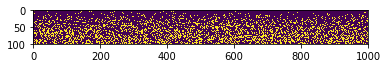

In [17]:
plt.imshow(nsMon[0].data)

In [18]:
def fire_times(spks):
    firing_times = []
    neurons = spks.shape[0]
    for n in range(neurons):
        firing_times.append(np.diff(np.argwhere(spks[n,:])[:,0]))
        
    return firing_times

In [19]:
ft =fire_times(nsMon[0].data)

In [23]:
fr = 1/ft

TypeError: unsupported operand type(s) for /: 'int' and 'list'

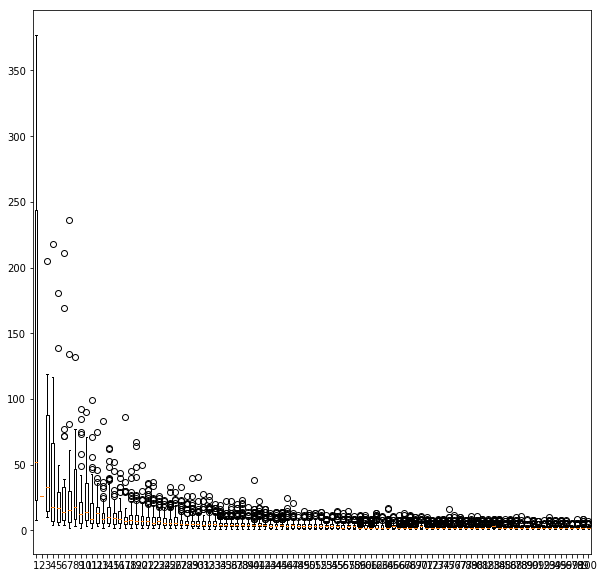

In [20]:
plt.figure(figsize=(10,10))
plt.boxplot(ft);

In [21]:
np.sum(nsMon[0].data, axis=1)

array([  6,   2,  13,  21,  19,  26,  29,  32,  49,  42,  62,  66,  84,
        64,  83,  85, 106,  98,  94, 116, 112, 120, 124, 136, 132, 125,
       147, 165, 163, 164, 181, 180, 172, 193, 190, 191, 207, 196, 218,
       222, 209, 227, 246, 245, 222, 237, 238, 254, 269, 266, 271, 275,
       295, 275, 301, 306, 316, 287, 330, 319, 342, 319, 329, 332, 333,
       356, 331, 334, 347, 332, 363, 357, 343, 352, 341, 360, 349, 373,
       364, 374, 360, 375, 348, 369, 374, 367, 373, 373, 382, 375, 376,
       378, 379, 374, 389, 377, 392, 382, 371, 395])

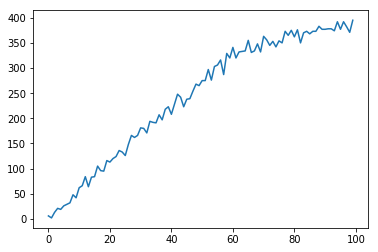

In [18]:
plt.plot(np.sum(nsMon[0].data, axis=1))

Add the spike generator which controls epochs

In [19]:
def test_firing_rates(net, monitor, time, trials):
    nspks = []
    total = time*trials
    net.run(total)
    net.disconnect()
    
    per_trial = np.split(monitor[0].data, trials, axis=1)
    fires = [np.sum(t, axis=1) for t in per_trial]
    return fires

In [20]:
fr_multi = test_firing_rates(net, nsMon, 1000, 10)

INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.103:42613
INFO:DRV:      Host server up..............Done 0.22s
INFO:DRV:      Encoding axons/synapses.....Done 0.03s
INFO:HST:  Args chip=0 cpu=0 /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/../bin/arm/simple_snn.bin --chips=1 --remote-relay=1 --epoch=0 
INFO:DRV:      Booting up..................Done 2.63s
INFO:DRV:      Encoding probes.............Done 1.11ms
INFO:DRV:      Transferring spikes.........Done 0.77ms
INFO:DRV:      Transferring probes.........Done 5.23ms
INFO:DRV:      Configuring registers.......Done 8.30ms
INFO:HST:  Lakemont_driver...
INFO:DRV:      Executing...................Done 2.74s
INFO:DRV:      Processing timeseries.......Done 0.48s
INFO:DRV:  Executor: 10000 timesteps.......Done 6.13s
INFO:HST:  chip=0 cpu=0 halted, status=0x0


In [21]:
fr_multi[0]

array([  6,   2,  13,  21,  19,  26,  29,  32,  48,  42,  62,  66,  84,
        64,  83,  84, 105,  96,  95, 116, 113, 120, 124, 136, 133, 126,
       148, 166, 162, 166, 181, 180, 171, 194, 192, 191, 207, 197, 218,
       223, 208, 228, 248, 242, 223, 238, 239, 254, 268, 265, 275, 275,
       297, 276, 303, 306, 316, 287, 329, 320, 341, 320, 332, 333, 334,
       355, 331, 334, 348, 332, 363, 356, 345, 353, 342, 354, 350, 373,
       365, 375, 362, 376, 350, 370, 373, 368, 373, 373, 383, 377, 377,
       378, 378, 374, 392, 377, 392, 382, 371, 395])

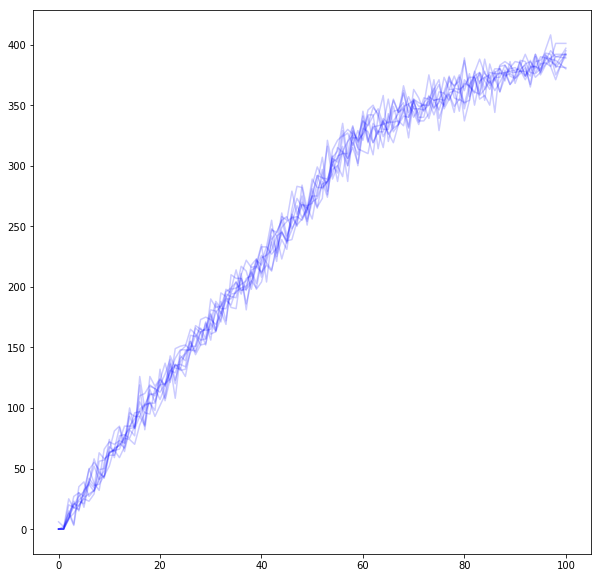

In [22]:
plt.figure(figsize=(10,10))
for f in fr_multi:
    plt.plot(weights - 50, f, color='b', alpha=0.2);

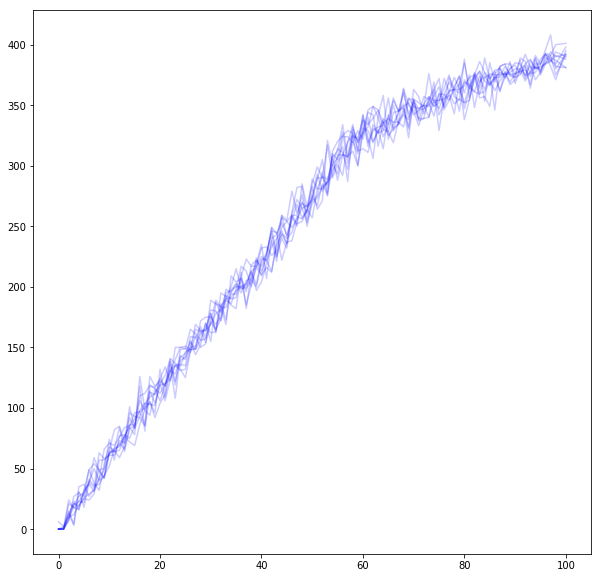

INFO:HST:  srun: Force Terminated job 451187
INFO:HST:  srun: Job step aborted: Waiting up to 32 seconds for job step to finish.
INFO:HST:  slurmstepd: error: *** STEP 451187.0 ON ncl-ext-ghrd-02 CANCELLED AT 2019-11-05T19:50:12 DUE TO TIME LIMIT ***
INFO:HST:  srun: error: ncl-ext-ghrd-02: task 0: Terminated


In [42]:
plt.figure(figsize=(10,10))
for f in fr_multi:
    plt.plot(weights - 50, f, color='b', alpha=0.2);